<a href="https://colab.research.google.com/github/diogorodrigues2002/Data-Mining-Project/blob/main/hierarchical_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
df=pd.read_csv('df_PCA.csv',delimiter=',')
df.head()

,customer_id,PC0,PC1,PC2,PC3,PC4,PC5,customer_region_2440,customer_region_2490,customer_region_4140,customer_region_4660,customer_region_8370,customer_region_8550,customer_region_8670,customer_region_Unknown,last_promo_DISCOUNT,last_promo_FREEBIE,last_promo_no_promotion_used,payment_method_CASH,payment_method_DIGI
0,1b8f824d5e,0.136414,0.000248,0.591799,0.789285,0.054109,0.422382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5d272b9dcb,0.136332,0.000000,0.594984,0.801680,0.036851,0.205378,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,f6d1b2ba63,0.214315,0.021475,0.301219,0.871834,0.354534,0.216267,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,180c632ed8,0.141628,0.006605,0.597401,0.797470,0.174912,0.282334,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4eb37a6705,0.141919,0.006840,0.597255,0.787897,0.085252,0.446357,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [3]:
df.set_index('customer_id',inplace=True)
metric_features=df.columns

In [4]:

def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt.

    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".

    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable

    sst = get_ss(df)  # get total sum of squares

    r2 = []  # where we will store the R2 metrics for each cluster solution

    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, metric=dist, linkage=link_method)


        # get cluster labels
        hclabels = cluster.fit_predict(df)


        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels', index=df.index)), axis=1)


        # compute ssw for each cluster labels
        ssw_labels = (df_concat.groupby(by='labels', group_keys=False).apply(lambda group: get_ss(group.drop(columns=['labels']))))


        # remember: SST = SSW + SSB
        ssb = sst - np.sum(ssw_labels)


        r2.append(ssb / sst)  # save the R2 of the given cluster solution

    return np.array(r2)

In [5]:
df_sample = df.sample(frac=0.1, random_state=42)

<ipython-input-4-d8662c69f5ba>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = (df_concat.groupby(by='labels', group_keys=False).apply(lambda group: get_ss(group.drop(columns=['labels']))))
<ipython-input-4-d8662c69f5ba>:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = (df_concat.groupby(by='labels', group_keys=False).apply(lambda group: get_ss(group.drop(columns=['labels']))))


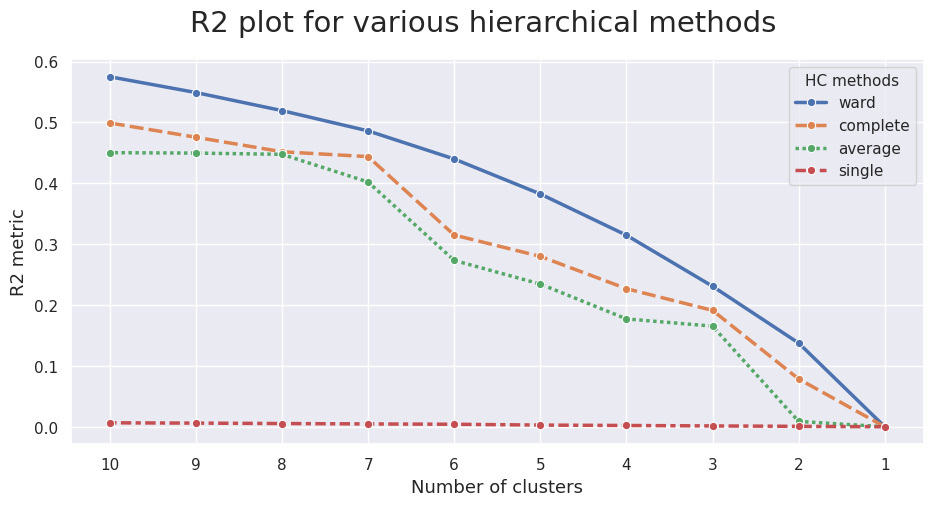

In [6]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df_sample[metric_features], link_method=link, max_nclus=max_nclus)
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [7]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_sample[metric_features])

array([2696, 2247, 2839, ...,    5,    2,    0])

In [8]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

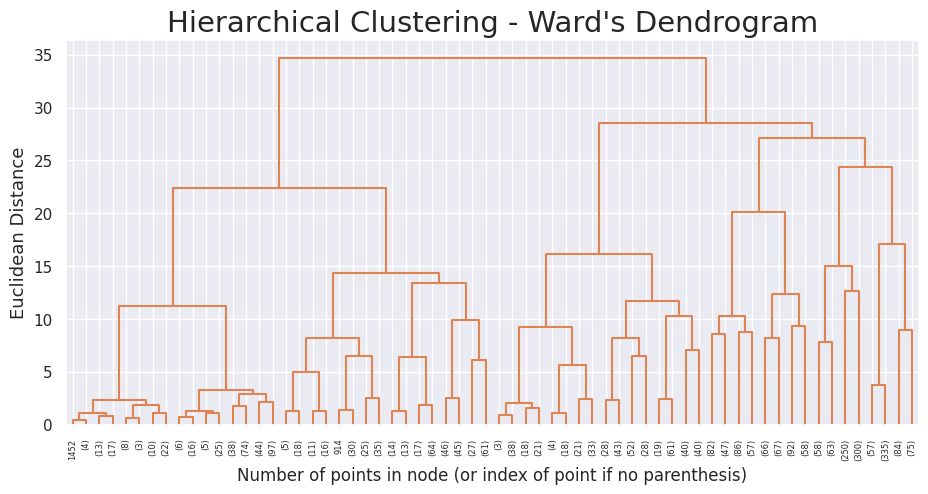

In [9]:
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

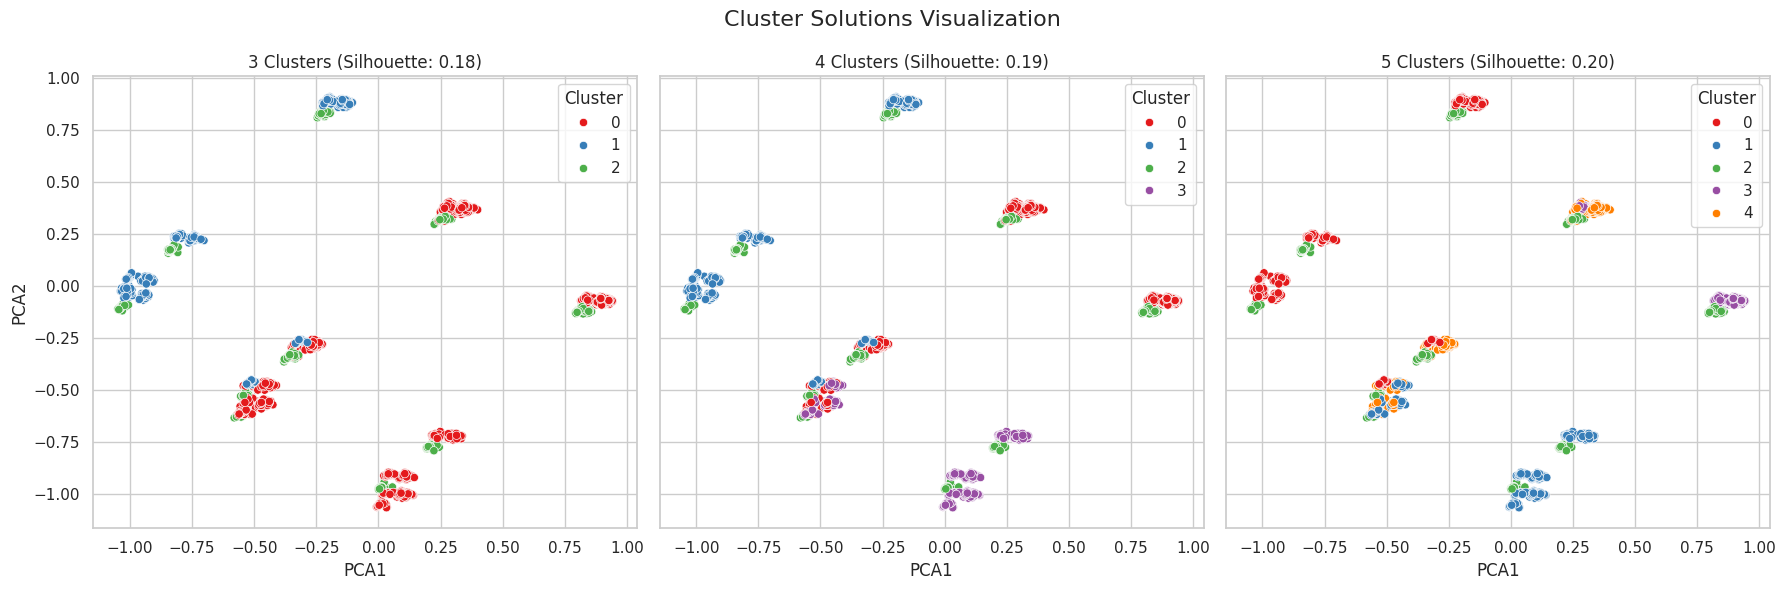

{3: 0.1823384046950523, 4: 0.19427637072586132, 5: 0.19583784373274027}

In [10]:
# Step 1: Perform hierarchical clustering for 3, 4, and 5 clusters
n_clusters_list = [3,4,5]
cluster_labels = {}

for n_clusters in n_clusters_list:
    cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    cluster_labels[n_clusters] = cluster.fit_predict(df_sample)

# Step 2: Reduce to 2 dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_sample)
reduced_df = pd.DataFrame(reduced_data, columns=["PCA1", "PCA2"])

# Step 3: Add cluster labels to the reduced dataframe
for n_clusters in n_clusters_list:
    reduced_df[f"Cluster_{n_clusters}"] = cluster_labels[n_clusters]

# Step 4: Compute silhouette scores
silhouette_scores = {
    n_clusters: silhouette_score(df_sample, cluster_labels[n_clusters])
    for n_clusters in n_clusters_list
}

# Step 5: Visualize clusters for each solution
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, n_clusters in enumerate(n_clusters_list):
    ax = axes[idx]
    sns.scatterplot(
        x="PCA1", y="PCA2", hue=f"Cluster_{n_clusters}", data=reduced_df, palette="Set1", ax=ax
    )
    ax.set_title(f"{n_clusters} Clusters (Silhouette: {silhouette_scores[n_clusters]:.2f})")
    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.legend(title="Cluster")

# Finalize and show the plots
fig.suptitle("Cluster Solutions Visualization", fontsize=16)
plt.tight_layout()
plt.show()

# Display silhouette scores
silhouette_scores

Choosing 5 clusters

In [11]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=5)
hc_labels = hclust.fit_predict(df[metric_features])

In [14]:
df_clean=pd.read_csv('df_clean.csv',delimiter=',')

In [15]:
df_clean.set_index('customer_id',inplace=True)

In [17]:
df_clean_numeric = df_clean.select_dtypes(include=['number'])
df_concat = pd.concat((df_clean_numeric, pd.Series(hc_labels, name='labels', index=df_clean.index)), axis=1)
df_concat.groupby('labels').mean()

,customer_age,vendor_count,product_count,is_chain,first_order,last_order,CUI_American,CUI_Asian,CUI_Beverages,CUI_Cafe,...,order_count,Diversity_Cuisine,costumer_time,Intensity_of_Activity,Customer_loyalty,product_intensity,Day_Week_Spread,week_highest,hour_spread,hour_highest
labels,,,,,,,,,,,,,,,,,,,,,
0,27.513923,3.182516,5.718413,3.384543,28.420061,62.256014,3.047262,4.778408,2.132567,0.436498,...,4.429153,1.712095,33.835954,7.809254,0.846618,1.282257,0.757521,3.741618,0.419306,13.034855
1,27.415445,3.087272,5.177507,2.204347,29.082002,63.898403,5.246348,20.023886,4.573896,0.026193,...,3.829409,1.771239,34.816400,9.069454,0.887237,1.361113,0.599743,3.459740,0.297008,7.996377
2,27.521704,3.024805,5.366136,2.686978,28.091939,63.459153,4.681380,10.798620,2.586622,0.774883,...,4.151793,1.783613,35.367215,8.889613,0.849823,1.298072,0.697570,3.658398,0.374457,11.166083
3,27.460084,2.652958,4.729492,2.336266,32.609413,60.692545,3.985397,8.373446,1.858843,0.720123,...,3.623928,1.651021,28.083132,7.047664,0.871522,1.337162,0.593170,3.753024,0.334518,11.684187
4,27.437268,3.051173,6.308982,2.596788,25.871361,67.829363,7.932296,5.968701,0.000000,2.402389,...,5.073055,2.134028,41.958002,9.573237,0.744210,1.227609,0.866268,3.794071,0.483894,14.010411


In [21]:
df_concat.to_csv('df_hieriarchical.csv')

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df[metric_features], hc_labels)
print("The average silhouette score is :", silhouette_avg)

The average silhouette score is : 0.19910659530006863


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(df[metric_features], hc_labels)
print("Calinski-Harabasz Index:", ch_score)

Calinski-Harabasz Index: 4434.749378468512


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(df[metric_features], hc_labels)
print("Davies-Bouldin Index:", db_score)

Davies-Bouldin Index: 1.862214288509237


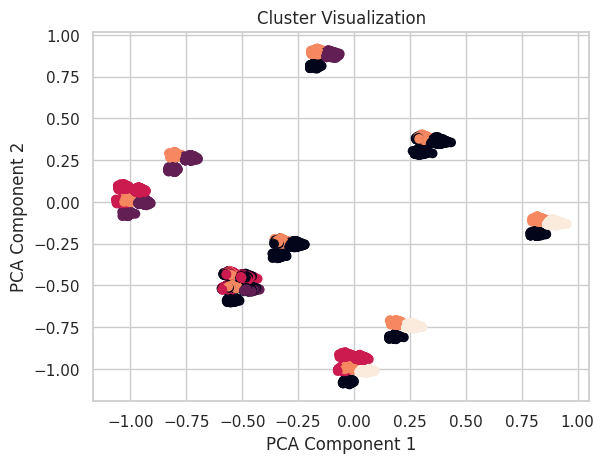

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df[metric_features])

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hc_labels)
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

choosing 9 clusters


In [ ]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=9)
hc_labels = hclust.fit_predict(df[metric_features])

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(df[metric_features], hc_labels)
print("The average silhouette score is :", silhouette_avg)

The average silhouette score is : 0.24380780801228646


In [ ]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(df[metric_features], hc_labels)
print("Calinski-Harabasz Index:", ch_score)

Calinski-Harabasz Index: 4441.333487535265


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(df[metric_features], hc_labels)
print("Davies-Bouldin Index:", db_score)

#better

Davies-Bouldin Index: 1.4569699546313766


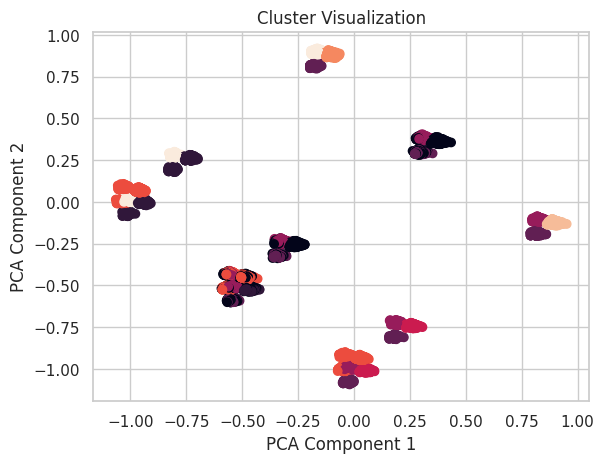

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df[metric_features])

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hc_labels)
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()